# Problema:

$S = \int d^Dx\left(\frac{1}{2}\partial_\mu \Phi(x)\partial_\mu \Phi(x) + \frac{1}{2}m^2 \Phi(x)^2 + \frac{g}{4!} \Phi(x)^4\right)$


In [22]:
# Librerias
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

In [23]:
@nb.njit
def contorno(i, n):
  return i % n

@nb.njit
def calc_k(a_s, a_t, lam, m, dim):
  """Calcula k y xi a partir de parámetros fundamentales."""
  xi = a_s / a_t
  k_s = (1 - 2*lam) / ((a_s*m)**2 + 2*xi**2 + 2*dim - 2)
  return xi * k_s, xi

@nb.njit
def N(phi, t, x, y, Nt, Nx, Ny, k, xi):
  """Calcula la suma de vecinos para un sitio (t, x, y)."""
  # Condiciones periodicas
  tp = contorno(t + 1, Nt); tm = contorno(t - 1, Nt)
  xp = contorno(x + 1, Nx); xm = contorno(x - 1, Nx)
  yp = contorno(y + 1, Ny); ym = contorno(y - 1, Ny)

  # Vecinos espaciales
  neigh_space = (
        phi[t, xp, y] + phi[t, xm, y] +
        phi[t, x, yp] + phi[t, x, ym]
  )
  # Vecinos temporales
  neigh_time = (
      phi[tp, x, y] + phi[tm, x, y]
  )

  return -(2 * k) / xi * neigh_space - 2 * k * xi * neigh_time

@nb.njit
def cambio_accion(phi, t, x, y, d, lam, Nt, Nx, Ny, k, xi):
  """Calcula el cambio en la acción (ΔS) para un cambio 'd'."""

  # 1. Obtenemos el valor de los vecinos
  vecinos = N(phi, t, x, y, Nt, Nx, Ny, k, xi)
  phi_actual = phi[t, x, y]

  # 2. Parámetros para el cambio en la accion
  a0 = vecinos + 2 * phi_actual * (1 + 2 * lam * (phi_actual**2 - 1))
  a1 = 1 + 2 * lam * (3 * phi_actual**2 - 1)
  a2 = 4 * lam * phi_actual
  a3 = lam

  # 3. Cálculo del cambio en la acción (ΔS)
  return d * (a0 + a1 * d + a2 * d**2 + a3 * d**3)

@nb.njit
def metropolis_sweep(phi, lam, delta, h, Nt, Nx, Ny, k, xi):
  """
  Realiza un barrido completo de Metropolis sobre la red 'phi'.
  Modifica 'phi' in-place.
  """
  aceptados = 0
  N_total = Nt * Nx * Ny

  # Eleccion de indices de forma aleatoria
  indices = np.arange(N_total)
  np.random.shuffle(indices)

  for idx in indices:
    # Convertir a (t, x, y)
    t = idx // (Nx * Ny)
    x = (idx // Ny) % Nx
    y = idx % Ny

    d = np.random.uniform(-delta, delta)

    dS = cambio_accion(phi, t, x, y, d, lam, Nt, Nx, Ny, k, xi)

    # Condición de Metropolis
    if dS < 0 or np.random.rand() < np.exp(-dS / h):
        phi[t, x, y] += d  # Aplicamos el cambio
        aceptados += 1

  return phi, aceptados / N_total  # Tasa de aceptación

@nb.njit
def autocorrelation_func(config, desfase, t_max):
    """
    Calcula la función de autocorrelación para una serie de mediciones.
    """
    z = config.shape[0]
    phi_mean = np.mean(config)
    phi_var = np.var(config)

    # Evita división por cero si la data es constante
    if phi_var == 0:
        t_range_fail = np.arange(0, t_max, desfase)
        return t_range_fail, np.zeros(len(t_range_fail))

    t_range = np.arange(0, t_max, desfase)
    autocorr_array = np.zeros(len(t_range))

    for idx, i in enumerate(t_range):
        # Tomar dos "rodajas" del array, separadas por i
        data_t = config[0 : z-i]
        data_t_plus_k = config[i : z]

        # Calcular el producto de las fluctuaciones
        covariance_k = np.mean( (data_t - phi_mean) * (data_t_plus_k - phi_mean) )

        # Normalizar por la varianza
        autocorr_array[idx] = covariance_k / phi_var

    return t_range[:len(autocorr_array)], autocorr_array


@nb.njit
def S_micro(phi_val, neighbor_sum, lam, mu):
    """
    Calcula la acción local S
    implicado por el polinomio de micro_update.
    """
    # Integral de: (4L)p^3 + (2L)p^2 + 2p + (N_sum + mu)
    return (lam * phi_val**4 +
            (2/3) * lam * phi_val**3 +
            phi_val**2 +
            (neighbor_sum + mu) * phi_val)

# Clase

In [24]:
class LatticeSimulation:
    def __init__(self, Nt, Nx, Ny, lam, m, a_s, a_t, dim, h, delta, u):
        """
        Inicializa la simulación, calcula parámetros derivados y crea la red.
        """
        print("Inicializando simulación...")
        # Guardar dimensiones
        self.Nt = Nt
        self.Nx = Nx
        self.Ny = Ny
        self.dim = dim

        # Guardar parámetros físicos
        self.lam = lam
        self.m = m
        self.a_s = a_s
        self.a_t = a_t

        # Guardar parámetros de simulación
        self.h = h
        self.delta = delta
        self.u = u

        # Calcular k y xi
        self.k, self.xi = calc_k(self.a_s, self.a_t, self.lam, self.m, self.dim)
        print(f"  Parámetros derivados: k = {self.k:.3f}, xi = {self.xi:.3f}")

        # Inicializar la red 'phi' con distribución normal
        self.phi = np.random.normal(scale=0.1, size=(Nt, Nx, Ny))
        print(f"  Red 'phi' creada con forma {self.phi.shape}")

        # Inicializar listas para guardar los resultados
        self.tasas_aceptacion = []
        self.mediciones_phi_mean = []
        # Generador de números aleatorios para la clase
        self.rng = np.random.default_rng()

    def run_simulation(self, num_sweeps, sweeps_mc, algorithm='Metropolis'):
        """
        Ejecuta el bucle de simulación completo, usando el algoritmo especificado.

        :param algorithm: 'Metropolis' o 'MicroUpdate'. También puede ser 'Ambos' o 'Alternado'.
        """
        algorithm = algorithm.lower()

        # ... (Inicialización y contadores) ...

        # Bucle externo (mediciones)
        for mc_step in range(sweeps_mc):

            # Bucle interno (decorrelación)
            for sweep in range(num_sweeps):

                # --- SELECCIÓN DEL ALGORITMO ---
                current_algorithm = algorithm

                # Lógica para alternar métodos (solo si se pide 'alternado' o 'ambos')
                if current_algorithm in ('ambos', 'alternado'):
                    # Si el índice del barrido es par, usa Metropolis; impar, usa Micro-Update
                    if sweep % 2 == 0:
                        current_algorithm = 'metropolis'
                    else:
                        current_algorithm = 'microupdate'

                # --- LLAMADA AL BARRIDO ---

                # 1. Llamar SOLO a Metropolis
                if current_algorithm == 'metropolis':
                    self.phi, rate = metropolis_sweep(
                        self.phi, self.lam, self.delta, self.h,
                        self.Nt, self.Nx, self.Ny, self.k, self.xi
                    )
                    self.tasas_aceptacion.append(rate)

                # 2. Llamar SOLO a Micro-Update
                elif current_algorithm == 'microupdate':
                    # Llamamos a Micro-Update para un solo barrido
                    rate = self.run_micro_update(num_sweeps=1)
                    self.tasas_aceptacion.append(rate)

                # Si se pasa un valor desconocido
                else:
                    raise ValueError(f"Algoritmo desconocido: {algorithm}")

                # AHORA tomamos UNA medición de la configuración descorrelacionada.
                medicion = np.mean(self.phi)
                self.mediciones_phi_mean.append(medicion)


    def get_results(self):
        """
        Devuelve las listas de resultados almacenadas.
        """
        return self.mediciones_phi_mean, self.tasas_aceptacion

    def analyze_autocorrelation(self, max_lag_percent, plot=True):
        """
        Calcula y grafica la función de autocorrelación
        para las mediciones de <phi> guardadas.
        """
        if not plot:
            print(f"Analizando autocorrelación (sin gráfico)\n")
        else:
            print("--- Analizando autocorrelación ---")

        # Obtener los datos (los que guardamos en run_simulation)
        mediciones = np.array(self.mediciones_phi_mean)

        if len(mediciones) < 20:
            print(f"Error: No hay suficientes mediciones ({len(mediciones)}) para el análisis.")
            return

        # Determinar el lag máximo
        num_mediciones = len(mediciones)
        t_max_lag = int(num_mediciones * max_lag_percent)

        print(f"Calculando sobre {num_mediciones} mediciones.")
        print(f"Lag máximo (t_max): {t_max_lag} (pasos de medición)")

        # Llamar a la función de cálculo Numba
        desfase = int(1/(2*self.a_s*self.m))
        k_lags, A_k = autocorrelation_func(mediciones, desfase, t_max_lag)

        sweeps_lags = k_lags

        # Graficar
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(sweeps_lags, A_k, marker='o', linestyle='-', label='A(k)')
            plt.axhline(0.1, color='red', linestyle='--', label='A(k) = 0.1')
            plt.xlabel("Lag (en Sweeps)")
            plt.ylabel("Autocorrelación A(k)")
            plt.title("Función de Autocorrelación")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.ylim(-0.05, 1.05)
            plt.show()

        try:
            # Encontrar dónde A(k) cruza 0.1
            tau_idx = np.where(np.array(A_k) < 0.1)[0][0]
            tau_sweeps = sweeps_lags[tau_idx]

            if not plot:
                 print(f"  > Tiempo de autocorrelación (A(k) < 0.1) ≈ {tau_sweeps} sweeps.")
            else:
                 print(f"\n> Tiempo de autocorrelación (A(k) < 0.1) ≈ {tau_sweeps} sweeps.")

            return tau_sweeps, A_k

        except IndexError:
            if not plot:
                print("  > No se pudo estimar tau (nunca bajó de 0.1).")
            else:
                print("\n> No se pudo estimar tau (nunca bajó de 0.1).")
            return np.nan, np.nan # Devuelve "Not a Number"

    def run_micro_update(self, num_sweeps):
          """
          Ejecuta N barridos usando el algoritmo "Micro Update".
          """
          print(f"--- Iniciando {num_sweeps} barridos de Micro-Update ---")

          for sweep in range(num_sweeps):
              for t in range(self.Nt):
                  for x in range(self.Nx):
                      for y in range(self.Ny):

                          # --- Decidir si proponer una actualización ---
                          if self.rng.uniform() >= self.u:
                              continue # Se mantiene el valor, saltar

                          # --- Calcular vecinos ---
                          neighbor_sum = N(self.phi, t, x, y,
                                          self.Nt, self.Nx, self.Ny,
                                          self.k, self.xi)

                          # --- Resolver dS(phi) = 0 ---
                          A = 4 * self.lam
                          B = 2 * self.lam
                          C = 2
                          D = neighbor_sum + self.delta

                          coeficientes = [A, B, C, D]

                          # --- Encontrar las raíces para phi  ---
                          raices = np.roots(coeficientes)

                          # Filtrar solo raíces reales
                          real_raices = raices[np.isreal(raices)].real

                          if not real_raices.size:
                              # No hay raíces reales, no se puede actualizar
                              continue

                          phi_propuesto = self.rng.choice(real_raices)

                          # --- Aceptar o Rechazar ---
                          phi_actual = self.phi[t, x, y]

                          # Usamos la función de acción S_micro
                          accion_actual = S_micro(phi_actual, neighbor_sum,
                                                        self.lam, self.delta)
                          accion_propuesta = S_micro(phi_propuesto, neighbor_sum,
                                                          self.lam, self.delta)

                          # Lógica de Metropolis estándar
                          delta_S = accion_propuesta - accion_actual

                          if delta_S < 0 or self.rng.random() < np.exp(-delta_S / self.h):
                              self.phi[t, x, y] = phi_propuesto

              #if (sweep + 1) % (num_sweeps // 10 or 1) == 0:
              #   print(f"  Progreso: {sweep + 1}/{num_sweeps} barridos...")

          print("--- Barridos de Micro-Update completados ---")

In [25]:
# Define todos tus parámetros en un solo lugar
params = {
    "Nt": 24,
    "Nx": 24,
    "Ny": 24,
    "lam": 0.0,
    "m": 0.5,
    "a_s": 1.0,     # Espaciado espacial
    "a_t": 1.0,     # Espaciado temporal
    "dim": 3,       # Dimensionalidad espacial
    "h": 1.0,       # Constante de Planck (o kT)
    "delta": 1.5,   # Rango de la propuesta de Metropolis
    "u": 1.0        # Probabilidad del Microupdate
}

# Crea el objeto de simulación
sim = LatticeSimulation(**params)

# Ejecuta la simulación completa
sim.run_simulation(num_sweeps=2000, sweeps_mc=10)

# Obtén tus resultados
mediciones, tasas = sim.get_results()

print(f"Número de mediciones: {len(mediciones)}")
print(f"Valor medio de phi: {np.mean(mediciones):.5f}")

Inicializando simulación...
  Parámetros derivados: k = 0.160, xi = 1.000
  Red 'phi' creada con forma (24, 24, 24)
Número de mediciones: 20000
Valor medio de phi: 0.00080


--- Iniciando calibración de 'delta' ---
Probando 14 valores de delta.
Ejecutando 100 barridos por cada valor.

Probando delta = 0.10...
Inicializando simulación...
  Parámetros derivados: k = 0.160, xi = 1.000
  Red 'phi' creada con forma (24, 24, 24)


<>:40: SyntaxWarning: invalid escape sequence '\d'
<>:40: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-489839116.py:40: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel("Delta ($\delta$)")



Probando delta = 0.60...
Inicializando simulación...
  Parámetros derivados: k = 0.160, xi = 1.000
  Red 'phi' creada con forma (24, 24, 24)

Probando delta = 1.10...
Inicializando simulación...
  Parámetros derivados: k = 0.160, xi = 1.000
  Red 'phi' creada con forma (24, 24, 24)

Probando delta = 1.60...
Inicializando simulación...
  Parámetros derivados: k = 0.160, xi = 1.000
  Red 'phi' creada con forma (24, 24, 24)

Probando delta = 2.10...
Inicializando simulación...
  Parámetros derivados: k = 0.160, xi = 1.000
  Red 'phi' creada con forma (24, 24, 24)

Probando delta = 2.60...
Inicializando simulación...
  Parámetros derivados: k = 0.160, xi = 1.000
  Red 'phi' creada con forma (24, 24, 24)

Probando delta = 3.10...
Inicializando simulación...
  Parámetros derivados: k = 0.160, xi = 1.000
  Red 'phi' creada con forma (24, 24, 24)

Probando delta = 3.60...
Inicializando simulación...
  Parámetros derivados: k = 0.160, xi = 1.000
  Red 'phi' creada con forma (24, 24, 24)

Proba

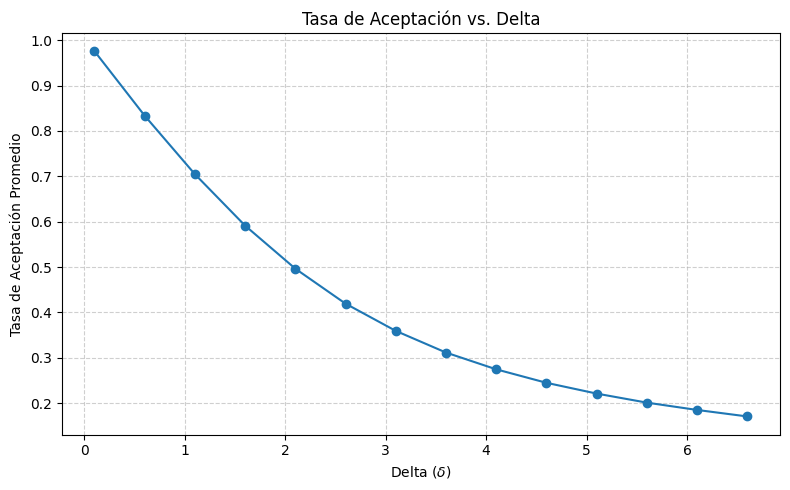

In [26]:

# -----------------------------------------------------------------
# SCRIPT DE CALIBRACIÓN DE DELTA
# -----------------------------------------------------------------

# Parámetros del experimento
delta_range = np.arange(0.1, 7.0, 0.5)  # Rango de deltas a probar
sweeps_por_delta = 100 # Barridos para estabilizar la tasa de aceptación

# Lista para guardar resultados
tasas_promedio = []

print(f"--- Iniciando calibración de 'delta' ---")
print(f"Probando {len(delta_range)} valores de delta.")
print(f"Ejecutando {sweeps_por_delta} barridos por cada valor.")

# 4. Bucle del experimento
for delta in delta_range:
    print(f"\nProbando delta = {delta:.2f}...")

    # Copiamos los parámetros base y añadimos el delta actual
    current_params = params.copy()
    current_params['delta'] = delta

    sim = LatticeSimulation(**current_params)

    # Ejecutamos la simulación
    sim.run_simulation(num_sweeps=sweeps_por_delta, sweeps_mc=5)

    # Obtenemos los resultados de esta simulación
    _ , tasas = sim.get_results()

    # Guardamos la tasa de aceptación PROMEDIO (es más estable que solo la última)
    tasas_promedio.append(np.mean(tasas))

print("\n--- Calibración completada ---")

# 5. Graficar los resultados
plt.figure(figsize=(8, 5))
plt.plot(delta_range, tasas_promedio, marker='o', linestyle='-')
plt.xlabel("Delta ($\delta$)")
plt.ylabel("Tasa de Aceptación Promedio")
plt.title("Tasa de Aceptación vs. Delta")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("Aceptacion_Vs_Delta",dpi=400, bbox_inches='tight')
plt.show()

# Autocorrelacion


--- Iniciando experimento: Autocorrelación vs. Masa (m) ---
Probando 3 valores de 'm'.

--- Probando m = 0.100 ---
Inicializando simulación...
  Parámetros derivados: k = 0.166, xi = 1.000
  Red 'phi' creada con forma (24, 24, 24)
Analizando autocorrelación (sin gráfico)

Calculando sobre 3000 mediciones.
Lag máximo (t_max): 900 (pasos de medición)
  > Tiempo de autocorrelación (A(k) < 0.1) ≈ 530 sweeps.

--- Probando m = 0.250 ---
Inicializando simulación...
  Parámetros derivados: k = 0.165, xi = 1.000
  Red 'phi' creada con forma (24, 24, 24)
Analizando autocorrelación (sin gráfico)

Calculando sobre 3000 mediciones.
Lag máximo (t_max): 900 (pasos de medición)
  > Tiempo de autocorrelación (A(k) < 0.1) ≈ 848 sweeps.

--- Probando m = 0.500 ---
Inicializando simulación...
  Parámetros derivados: k = 0.160, xi = 1.000
  Red 'phi' creada con forma (24, 24, 24)
Analizando autocorrelación (sin gráfico)

Calculando sobre 3000 mediciones.
Lag máximo (t_max): 900 (pasos de medición)
  > Tie

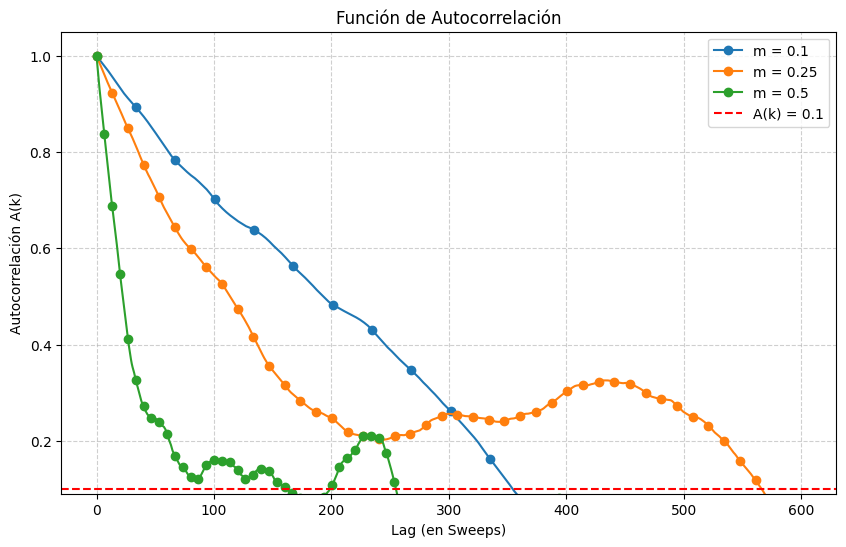

In [33]:
params_base = {
    "Nt": 24,
    "Nx": 24,
    "Ny": 24,
    "lam": 0.0,
    "a_s": 1.0,     # Espaciado espacial
    "a_t": 1.0,     # Espaciado temporal
    "dim": 3,       # Dimensionalidad espacial
    "h": 1.0,       # Constante de Planck (o kT)
    "delta": 2.0,   # Rango de la propuesta de Metropolis
    "u": 1.0        # Probabilidad del Microupdate
}

m_range = [0.1,0.25,0.5]

# Lista para guardar resultados
rho = []
n = 3

n_sweeps = 5
n_mc = 600
run_max_lag = 0.3

print(f"--- Iniciando experimento: Autocorrelación vs. Masa (m) ---")
print(f"Probando {len(m_range)} valores de 'm'.")
plt.figure(figsize=(10, 6))

for m_valor in m_range:
    print(f"\n--- Probando m = {m_valor:.3f} ---")

    # Preparamos los parámetros para esta simulación específica
    current_params = params_base.copy()
    current_params['m'] = m_valor

    # Creamos una SIMULACIÓN NUEVA E INDEPENDIENTE
    sim = LatticeSimulation(**current_params)

    # Ejecutamos la simulación
    sim.run_simulation(
        num_sweeps=n_sweeps,
        sweeps_mc=n_mc,
        algorithm = "Metropolis"
    )

    # Analizamos y guardamos el resultado
    tau, A_k = sim.analyze_autocorrelation(run_max_lag, plot=False)
    x = np.linspace(0,600,len(A_k))
    # Graficamos
    plt.plot(x, A_k, marker='o', linestyle='-',label=f"m = {m_valor}", markevery=10)

#rho_array = np.array(rho)
print("\n--- Experimento completado ---")

# Graficar los resultados
plt.axhline(0.1, color='red', linestyle='--', label='A(k) = 0.1')
plt.xlabel("Lag (en Sweeps)")
plt.ylabel("Autocorrelación A(k)")
plt.title("Función de Autocorrelación")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0.09, 1.05)
plt.show()

# Microcanonical Update

In [28]:
params_base = {
    "Nt": 24,
    "Nx": 24,
    "Ny": 24,
    "lam": 0.0,
    "a_s": 1.0,     # Espaciado espacial
    "a_t": 1.0,     # Espaciado temporal
    "dim": 3,       # Dimensionalidad espacial
    "h": 1.0,       # Constante de Planck (o kT)
    "delta": 2.5,   # Rango de la propuesta de Metropolis
    "u": 1.0        # Probabilidad del Microupdate
}

m_range = [0.1,0.25,0.5]

# Lista para guardar resultados
rho = []
n = 3

n_sweeps = 10
n_mc = 600
run_max_lag = 0.3

print(f"--- Iniciando experimento: Autocorrelación vs. Masa (m) ---")
print(f"Probando {len(m_range)} valores de 'm'.")
plt.figure(figsize=(10, 6))

for m_valor in m_range:
    print(f"\n--- Probando m = {m_valor:.3f} ---")

    # Preparamos los parámetros para esta simulación específica
    current_params = params_base.copy()
    current_params['m'] = m_valor

    # Creamos una SIMULACIÓN NUEVA E INDEPENDIENTE
    sim = LatticeSimulation(**current_params)

    # Ejecutamos la simulación
    sim.run_simulation(
        num_sweeps=5,
        sweeps_mc=n_mc,
        algorithm = "Ambos"
    )


    # Analizamos y guardamos el resultado
    tau, A_k = sim.analyze_autocorrelation(run_max_lag, plot=False)
    x = np.linspace(0,100,len(A_k))
    # Graficamos
    plt.plot(x, A_k, marker='o', linestyle='-',label=f"m = {m_valor}", markevery=40)

#rho_array = np.array(rho)
print("\n--- Experimento completado ---")

# Graficar los resultados
plt.axhline(0.1, color='red', linestyle='--', label='A(k) = 0.1')
plt.xlabel("Lag (en Sweeps)")
plt.ylabel("Autocorrelación A(k)")
plt.title("Función de Autocorrelación")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(-0.09, 1.05)
plt.show()

--- Iniciando experimento: Autocorrelación vs. Masa (m) ---
Probando 3 valores de 'm'.

--- Probando m = 0.100 ---
Inicializando simulación...
  Parámetros derivados: k = 0.166, xi = 1.000
  Red 'phi' creada con forma (24, 24, 24)
--- Iniciando 1 barridos de Micro-Update ---
  Progreso: 1/1 barridos...
--- Barridos de Micro-Update completados ---
--- Iniciando 1 barridos de Micro-Update ---
  Progreso: 1/1 barridos...
--- Barridos de Micro-Update completados ---
--- Iniciando 1 barridos de Micro-Update ---
  Progreso: 1/1 barridos...
--- Barridos de Micro-Update completados ---
--- Iniciando 1 barridos de Micro-Update ---
  Progreso: 1/1 barridos...
--- Barridos de Micro-Update completados ---
--- Iniciando 1 barridos de Micro-Update ---
  Progreso: 1/1 barridos...
--- Barridos de Micro-Update completados ---
--- Iniciando 1 barridos de Micro-Update ---
  Progreso: 1/1 barridos...
--- Barridos de Micro-Update completados ---
--- Iniciando 1 barridos de Micro-Update ---
  Progreso: 1/1 

KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>